## CIFAR 10 notebook for TEG


## Importamos las librerias necesarias

In [2]:
import numpy as np
import matplotlib.pyplot as plt

#PyTorch stuff
import torch
torch.manual_seed(0) # => importante para replicar los experimentos. Setea la semilla para la generacion de numeros aleatorios
from torch import optim, nn
from torch.nn import functional as F
from torchvision import transforms as T
from torchvision import models, datasets
from torch.utils.data import DataLoader, Dataset, random_split

from classes import CyclicLRGiselt_Denis
import random

## Usamos la GPU en caso de estar disponible


In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Estamos usando: {device}')

Estamos usando: cuda


##  Datasets y Dataloaders

In [4]:
PATH = './Dataset/cifar-10' # Path en donde queramos colocar le Dataset
TRAIN_SIZE = 50000 # Tamano del set de entrenamiento
VAL_SIZE = 5000 # Tamano del set de validacion
TEST_SIZE = 5000 #Tamano del set de pruebas
MINIBATCH_SIZE = 512 #Tamano del minibatch

#T.Compose hace que al generar cada minibatch se aplique la serie de transformaciones descritas
transform_cifar10_train = T.Compose([
                T.RandomHorizontalFlip(p=0.3), #Con probabilidad de 0.3 (30%) hara un flip horizontal sobre el set de entrenamiento
                T.ColorJitter(brightness=0.1, contrast=0.1, hue = 0.05), # Realice ajustes de brillo, contraste y ajuste de color
                T.RandomApply([T.RandomRotation(10), #Rotacion de 10 grados
                               T.Resize(40), #Hacemos aumento de la imagen a 40x40 pixeles
                               T.CenterCrop(32)], #Recortamos los 32 pixeles del centro de la imagens
                               p = 0.1), #Probabilidad de realizar esto
                T.ToTensor(), #Convertimos a Tensor
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.262]) #Medias y desviaciones estandar para cada canal RGB de CIFAR 10 https://github.com/facebookarchive/fb.resnet.torch/issues/180
            ])
transform_cifar10_test = T.Compose([
                T.ToTensor(), #Convertimos a Tensor
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.262]) #Medias y desviaciones estandar para cada canal RGB de CIFAR 10 https://github.com/facebookarchive/fb.resnet.torch/issues/180
            ])

# Training set loader
cifar10_train = datasets.CIFAR10(PATH, 
                                train=True, 
                                download=True,
                                transform=transform_cifar10_train) #Descargamos el set de entrenamiento en caso de no tenerlo
train_loader = DataLoader(cifar10_train, 
                          batch_size=MINIBATCH_SIZE, 
                          shuffle = True) #Creamos el dataloader. El dataloader permite tener un iterable (x,y) sobre el set de CIFAR 10

# Validation and test sets
test_dataset = datasets.CIFAR10(PATH, 
                                train=False, 
                                download=True, 
                                transform=transform_cifar10_test) #Descargamos datos de prueba
val_dataset, test_dataset = random_split(test_dataset, [VAL_SIZE, TEST_SIZE]) #Hacemos un spit random para validacion y test

val_loader = DataLoader(val_dataset, batch_size=MINIBATCH_SIZE, shuffle = True)

test_loader = DataLoader(test_dataset, batch_size=MINIBATCH_SIZE, shuffle = True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
for i,(x, y) in enumerate(test_loader):
    print(i, x.shape, y.shape)

0 torch.Size([512, 3, 32, 32]) torch.Size([512])
1 torch.Size([512, 3, 32, 32]) torch.Size([512])
2 torch.Size([512, 3, 32, 32]) torch.Size([512])
3 torch.Size([512, 3, 32, 32]) torch.Size([512])
4 torch.Size([512, 3, 32, 32]) torch.Size([512])
5 torch.Size([512, 3, 32, 32]) torch.Size([512])
6 torch.Size([512, 3, 32, 32]) torch.Size([512])
7 torch.Size([512, 3, 32, 32]) torch.Size([512])
8 torch.Size([512, 3, 32, 32]) torch.Size([512])
9 torch.Size([392, 3, 32, 32]) torch.Size([392])


### Mostrar datos

La imagen muestreada representa un: airplane


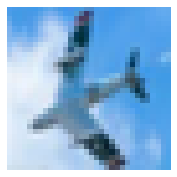

In [6]:
classes = train_loader.dataset.classes
def plot_figure(image):
    plt.figure(figsize=(3,3))
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(test_loader))
print(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)

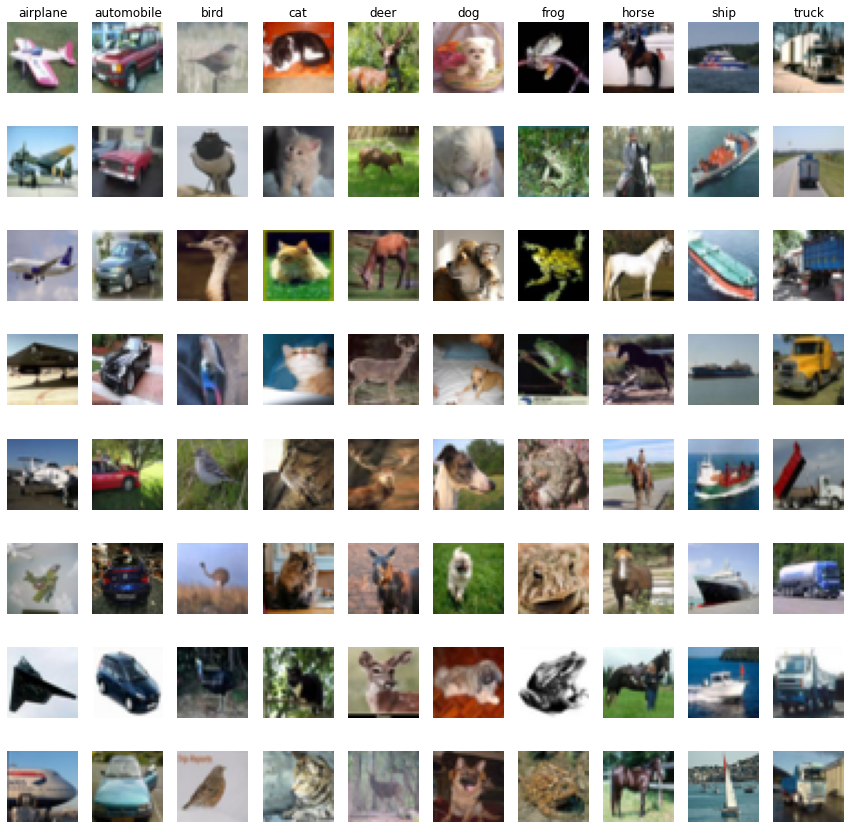

In [7]:
def plot_cifar10_grid():
    classes = train_loader.dataset.classes
    total_samples = 8
    plt.figure(figsize=(15,15))
    for label, sample in enumerate(classes):
        class_idxs = np.flatnonzero(label == np.array(train_loader.dataset.targets))
        sample_idxs = np.random.choice(class_idxs, total_samples, replace = False)
        for i, idx in enumerate(sample_idxs):
            plt_idx = i*len(classes) + label + 1
            plt.subplot(total_samples, len(classes), plt_idx)
            plt.imshow(train_loader.dataset.data[idx])
            plt.axis('off')
            
            if i == 0: plt.title(sample)
    plt.show()

plot_cifar10_grid() 


#### Accuracy

In [8]:
len(val_loader)

10

In [9]:
def accuracy(model, loader):
    '''
    model - PyTorch model
    loader - PyTorch dataloader
    
    Returns:
    
    '''
    correct = 0
    total = 0
    cost = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            cost += (F.cross_entropy(scores, y)).item()
            _, pred = scores.max(dim=1)
            correct += (pred == y).sum()
            total += pred.size(0)
        #Aca agregue retornar el costo tambien para poder saber la funcion de costo para el set de test o validacion
        return cost/len(loader), float(correct)/total

#### Buscar learning rate

In [19]:
def find_lr(model, optimiser, start_val = 1e-6, end_val = 1, beta = 0.99, loader = train_loader):
    n = len(loader) - 1
    factor = (end_val / start_val)**(1/n)
    lr = start_val
    optimiser.param_groups[0]['lr'] = lr #this allows you to update the learning rate
    avg_loss, loss, acc = 0., 0., 0.
    lowest_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    accuracies = []
    model = model.to(device=device)
    for i, (x, y) in enumerate(loader, start=1):
        x = x.to(device = device, dtype = torch.float32)
        y = y.to(device = device, dtype = torch.long)
        optimiser.zero_grad()
        scores = model(x)
        cost = F.cross_entropy(input=scores, target=y)
        loss = beta*loss + (1-beta)*cost.item()
        #bias correction
        avg_loss = loss/(1 - beta**i)
        
        acc_ = ((torch.argmax(scores, dim=1) == y).sum()/scores.size(0)) 
#         acc = beta*acc + (1-beta)*acc_.item()
#         avg_acc = acc/(1 - beta**i)
        #if loss is massive stop
        if i > 1 and avg_loss > 4 * lowest_loss:
            print(f'from here{i, cost.item()}')
            return log_lrs, losses, accuracies
        if avg_loss < lowest_loss or i == 1:
            lowest_loss = avg_loss
        
#         accuracies.append(acc.item())
        accuracies.append(acc_.item())
#         accuracies.append(avg_acc)
        losses.append(avg_loss)
        log_lrs.append(lr)
        #step
        cost.backward()
        optimiser.step()
        #update lr
        print(f'cost:{cost.item():.4f}, lr: {lr:.4f}, acc: {acc_.item():.4f}')
        lr *= factor
        optimiser.param_groups[0]['lr'] = lr
        
    return log_lrs, losses, accuracies     

### Loop de Entrenamiento

In [11]:
def train(model, optimiser, scheduler = None, epochs = 100):
    model = model.to(device = device)
    val_loss_history = []
    train_loss_history = []
    val_acc_history = []
    train_acc_history = []
    lrs = []
    train_cost = 0.
    val_cost = 0.
    val_acc = 0.
    train_cost_acum = 0
    for epoch in range(epochs):
        if(val_acc >= 0.95):
            break;
        train_correct_num  = 0
        train_total = 0
        train_cost_acum = 0
        for mb, (x, y) in enumerate(train_loader, start=1):
            model.train()
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            cost = F.cross_entropy(input=scores, target=y)
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()
            train_correct_num += (torch.argmax(scores, dim=1) == y).sum()
            train_total += scores.size(0)        
            train_acc = float(train_correct_num)/train_total  
            train_acc_history.append(train_acc)
            train_acc = float(train_correct_num)/train_total
            train_cost_acum += cost.item()
            train_cost = train_cost_acum/len(train_loader)
            train_loss_history.append(cost.item())
        #if using scheduler
        if scheduler: 
            scheduler.step()
            lr = scheduler.get_last_lr()[0]
        else:
            lr = optimiser.param_groups[0]["lr"]
#             train_cost = train_cost_acum/mb
        val_cost, val_acc = accuracy(model, val_loader)

        val_loss_history.append(val_cost)
        val_acc_history.append(val_acc)
#             lrs.append(scheduler.get_last_lr()[0])
        lrs.append(lr)
        #f'last lr: {scheduler.get_last_lr()[0]:6f},
        
        print(f'Epoch:{epoch}, train cost: {train_cost:.6f}, val cost: {val_cost:.6f},'
                      f' train acc: {train_acc:.4f}, val acc: {val_acc:4f}, total: {train_total},'
                      f' lr: {lr:.6f}')
        
    return train_loss_history, val_loss_history, train_acc_history, val_acc_history, lrs

# ResNet56
https://arxiv.org/pdf/1512.03385.pdf

In [12]:
conv_k_3 = lambda channel1, channel2, stride: nn.Conv2d(channel1, channel2, stride = stride, kernel_size=3, padding=1)

In [13]:
class residual_block(nn.Module):
    '''

    '''
    def __init__(self, in_channel, out_channel, stride=1, change_size = True):
        super().__init__()
        self.conv1 = conv_k_3(in_channel, out_channel, stride)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.conv2 = conv_k_3(out_channel, out_channel, 1)
        self.bn2 = nn.BatchNorm2d(out_channel)
        #for changing activation map sizes
        self.change_size = change_size
        if change_size:
            self.residual = nn.Sequential(nn.Conv2d(in_channel, 
                                                    out_channel, 
                                                    kernel_size=1,
                                                    stride=stride),
                                         nn.BatchNorm2d(out_channel)
                                         )      
    def forward(self, x):
        identity = x if not self.change_size else self.residual(x)
        y = F.relu(self.bn1(self.conv1(x)))
        y = self.bn2(self.conv2(y))
        y += identity
        return F.relu(y)


In [14]:
class ResNet56(nn.Module):
    def __init__(self, n=9, num_classes=10):
        super().__init__()
        self.conv1 = conv_k_3(3, 16, stride = 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.block1 = self.create_block(n=9, in_channel=16, 
                                        out_channel=16, stride=1, 
                                        change_size=False)
        self.block2 = self.create_block(n=9, in_channel=16, 
                                        out_channel=32, stride=2)
        self.block3 = self.create_block(n=9, in_channel=32, 
                                        out_channel=64, stride=2)
        self.fc = nn.Linear(64, num_classes)

    def create_block(self, n, in_channel, out_channel, stride, change_size=True):
        block = [residual_block(in_channel, out_channel, stride, change_size=change_size)]
        for i in range(n-1):
            block.append(residual_block(out_channel, out_channel, stride=1, change_size=False))
        return nn.Sequential(*block)   
        
    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)))
        y = self.block3(self.block2(self.block1(y)))
        y = F.adaptive_avg_pool2d(y, 1)
        return self.fc(y.view(y.size(0), -1))      
       
        

In [15]:
model_resnet56 = ResNet56()

In [16]:
print(model_resnet56)

ResNet56(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): Sequential(
    (0): residual_block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): residual_block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): residual_block(
      (conv1): Con

In [17]:
# model_resnet56 = ResNet56()
optimizer = torch.optim.SGD(model_resnet56.parameters(),
                                     lr=0.1,
                                     weight_decay=1e-4) #Probar con wight_decay en las libretas anteriores

In [20]:
lg_lr, losses, accuracies = find_lr(model_resnet56, 
                                    optimizer,
                                    start_val=1e-6, 
                                    end_val=10)

cost:2.6941, lr: 0.0000, acc: 0.1016
cost:2.6994, lr: 0.0000, acc: 0.0781
cost:2.7022, lr: 0.0000, acc: 0.1230
cost:2.7567, lr: 0.0000, acc: 0.0977
cost:2.7328, lr: 0.0000, acc: 0.1094


KeyboardInterrupt: 

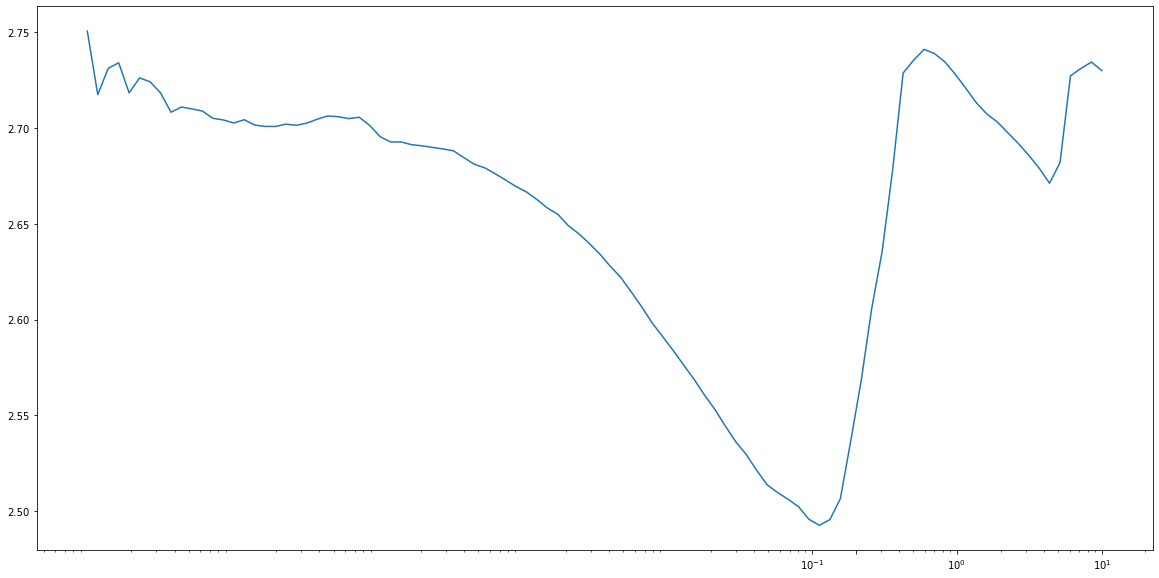

In [ ]:
f1, ax1 = plt.subplots(figsize=(20,10))
# ax1.plot(lr[60:-2], losses[60:-2])
ax1.plot(lg_lr, losses)
ax1.set_xscale('log')
ax1.set_xticks([1e-1,2e-1, 1, 10])
ax1.get_xaxis().get_major_formatter().labelOnlyBase = False
plt.show()

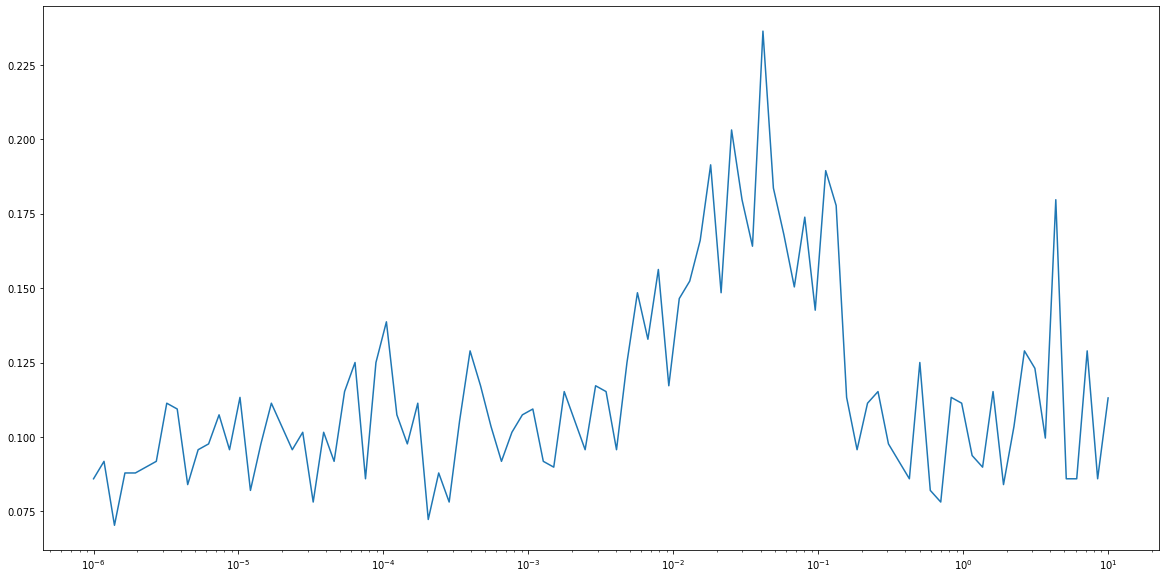

In [ ]:
f1, ax1 = plt.subplots(figsize=(20,10))
# ax1.plot(lr[60:-2], losses[60:-2])
ax1.plot(lg_lr, accuracies)
ax1.set_xscale('log')
# ax1.set_xticks([1e-1, 2e-1,5e-1, 7e-1, 1, 10])
ax1.get_xaxis().get_major_formatter().labelOnlyBase = False
plt.show()

In [ ]:
model_resnet56 = ResNet56()
optimizer = torch.optim.SGD(model_resnet56.parameters(),
                                     lr=0.1, momentum=0.95,
                                     weight_decay=1e-4)
epochs = 20
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
#                                                 max_lr=2e-1, 
#                                                 steps_per_epoch=len(train_loader), 
#                                                 epochs = epochs, pct_start=0.43, 
#                                                 div_factor=10, 
#                                                 final_div_factor=1000, 
#                                                 three_phase=True, verbose=False
#                                             )

clr_fn = lambda x, y: random.uniform(x, y)

scheduler = CyclicLRGiselt_Denis(optimizer,
                                 base_lr=0.01, 
                                 max_lr=2e-1,
                                 step_size_up=3, 
                                 scale_fn=clr_fn,
                                 scale_mode='chipichipi', 
                                 cycle_momentum=False)

train_loss_history, val_loss_history, train_acc_history, val_acc_history, lrs = train(
                                model_resnet56, 
                                optimiser=optimizer,
                                scheduler=scheduler,
                                epochs = epochs
                                )

Epoch:0, train cost: 2.531669, val cost: 2.147126, train acc: 0.1317, val acc: 0.186800, total: 50000, lr: 0.193630


In [ ]:
accuracy(model_resnet56, test_loader)

(0.6208799123764038, 0.7916)

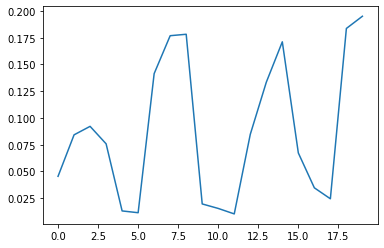

In [ ]:
plt.plot(lrs)
plt.show()

In [ ]:
print(lrs)

[0.04542452866420954, 0.08419409980559053, 0.09213164976475724, 0.07581446343602859, 0.013089186084357813, 0.011415742384221734, 0.14142193486197174, 0.17684106435058922, 0.17818691506631426, 0.01961854472955281, 0.015415848840759229, 0.010298348712388833, 0.08462679868613421, 0.13332817415735004, 0.17111606897769938, 0.06727473080709118, 0.03468721736035549, 0.02444413074132539, 0.18361477652172564, 0.19502561132413598]
